In [23]:
# 在 notebook 第一格執行
%pip uninstall -y tensorflow keras keras-nightly keras-Preprocessing keras-vis h5py
%pip uninstall -y protobuf numpy ml_dtypes
%pip install numpy==1.24.3 protobuf==3.20.3 ml_dtypes==0.2.0
%pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Found existing installation: h5py 3.13.0
Uninstalling h5py-3.13.0:
  Successfully uninstalled h5py-3.13.0
Note: you may need to restart the kernel to use updated packages.
Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
Found existing installation: ml-dtypes 0.2.0
Uninstalling ml-dtypes-0.2.0:
  Successfully uninstalled ml-dtypes-0.2.0
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.24.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached protobuf-3.20.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 

In [24]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [25]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

{'name': 'kaggle.json', 'type': 'application/json', 'size': 69, 'content': <memory at 0x7540bd35cac0>, 'last_modified': datetime.datetime(2025, 5, 17, 11, 46, 32, 106000, tzinfo=datetime.timezone.utc)}
kaggle.json 已成功儲存至 /home/jovyan/.kaggle/kaggle.json


In [26]:
!kaggle datasets list -s cifar


ref                                                     title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
fedesoriano/cifar100                                    CIFAR-100 Python                                  168517809  2020-12-26 08:37:10.143000          12247        176  1.0              
pankrzysiu/cifar10-python                               CIFAR-10 Python                                   340613496  2018-01-27 13:42:40.967000          14758        252  0.75             
petitbonney/cifar10-image-recognition                   CIFAR-10                                         1007971063  2019-10-01 12:50:23.227000           2854         26  0.8235294        
valentynsichkar/cifar10-preprocessed                   

In [27]:
!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification


import pandas as pd
import numpy as np

labels = pd.read_csv('dog-breed-identification/labels.csv')


cp: cannot stat 'kaggle.json': No such file or directory
100%|████████████████████████████████████████▊| 688M/691M [00:03<00:00, 192MB/s]
100%|█████████████████████████████████████████| 691M/691M [00:03<00:00, 187MB/s]


In [28]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

100%|██████████| 10222/10222 [00:49<00:00, 204.89it/s]


In [29]:
 #自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [30]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # 隨機縮放裁切
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 使用 ImageNet 的 mean/std
                         (0.229, 0.224, 0.225)),
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [31]:
# 建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import collections
from collections import Counter

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)

# 計算資料數量與切分比例
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 取得 training set 的原始 indices
train_indices = train_dataset.indices  # 是 dataset 中對應的索引
train_labels = [dataset.labels[i] for i in train_indices]

# 計算類別樣本數與每個 sample 權重
label_counts = Counter(train_labels)
class_sample_counts = [label_counts[i] for i in range(len(label_counts))]
sample_weights = [1.0 / class_sample_counts[label] for label in train_labels]

# 建立 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 建立 DataLoader（train 用 sampler, val 用 shuffle=False）
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 顯示類別分布（驗證分布仍可看是否合理）
val_labels = [dataset.labels[i] for i in val_dataset.indices]
print("Train label distribution:", Counter(train_labels))
print("Val label distribution:", Counter(val_labels))
#這是調平衡的

Train label distribution: Counter({97: 99, 73: 97, 94: 94, 42: 93, 3: 91, 52: 91, 100: 89, 109: 88, 1: 88, 11: 87, 69: 86, 87: 86, 7: 86, 61: 84, 9: 84, 68: 84, 26: 84, 75: 83, 59: 82, 88: 82, 102: 81, 6: 80, 117: 79, 17: 77, 80: 77, 56: 77, 13: 76, 84: 76, 86: 76, 93: 76, 70: 75, 101: 75, 60: 75, 78: 74, 8: 73, 98: 72, 92: 72, 55: 71, 90: 71, 30: 71, 10: 70, 95: 70, 39: 70, 35: 70, 28: 70, 119: 69, 118: 69, 79: 69, 74: 68, 20: 68, 63: 68, 54: 67, 19: 67, 71: 67, 12: 67, 50: 67, 33: 67, 110: 67, 82: 67, 40: 66, 115: 66, 57: 66, 64: 66, 2: 66, 14: 66, 99: 65, 15: 65, 67: 64, 53: 64, 111: 64, 62: 64, 114: 63, 104: 63, 5: 63, 24: 63, 76: 62, 41: 62, 112: 61, 81: 61, 31: 61, 105: 61, 96: 61, 107: 61, 58: 61, 4: 61, 21: 61, 77: 60, 27: 60, 47: 60, 116: 59, 103: 59, 18: 59, 34: 58, 51: 58, 85: 58, 29: 58, 32: 58, 89: 58, 46: 58, 65: 58, 36: 58, 113: 57, 37: 57, 0: 57, 91: 57, 66: 56, 22: 56, 108: 56, 83: 55, 38: 55, 106: 55, 44: 54, 45: 54, 16: 54, 25: 54, 23: 54, 48: 53, 49: 50, 72: 50, 43:

In [32]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [33]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break

Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


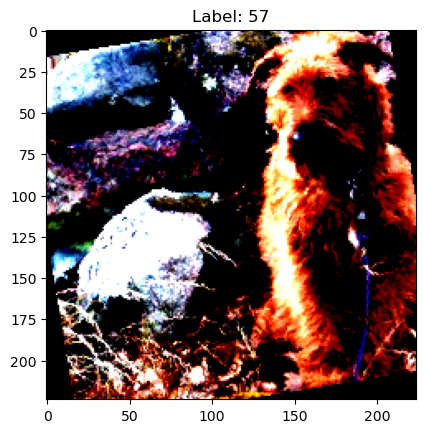

In [34]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [35]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = 120  # Dog Breed Identification 有 120 類別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 載入預訓練模型並修改最後一層
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

num_classes = len(dataset.class_to_idx)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

# 搬移到裝置（GPU 或 CPU）
model = model.to(device)

In [14]:
from collections import Counter
num_epochs = 30
# 計算各類別的樣本數
label_counts = Counter(dataset.labels)
num_classes = len(label_counts)
class_counts = [label_counts[i] for i in range(num_classes)]

# 計算每個類別的權重：樣本數越少，權重越高
weights = [1.0 / c for c in class_counts]
weights = torch.tensor(weights, dtype=torch.float).to(device)

# 使用 class weights + label smoothing
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


In [ ]:
import numpy as np

def mixup_data(x, y, alpha=0.4):
    '''混合兩張圖片與其標籤'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''計算 MixUp 混合損失'''
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

def get_dataloaders(image_size, batch_size):
    transform_train = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    transform_val = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_dataset = ImageFolder(train_dir, transform=transform_train)
    val_dataset = ImageFolder(val_dir, transform=transform_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader


In [ ]:
from torchvision import transforms
from PIL import Image

def collate_with_resize(batch, image_size):
    images, labels = zip(*batch)
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # 直接縮放 tensor
    ])
    images = [transform(img) if isinstance(img, torch.Tensor) else transform(transforms.ToTensor()(img)) for img in images]
    return torch.stack(images), torch.tensor(labels)


In [15]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''儲存目前最佳模型'''
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [41]:
small_image_epochs = 3
small_size = 128
large_size = 224
batch_size = 32
num_epochs = 10

early_stopping = EarlyStopping(patience=7, verbose=True, path='best_resnet50.pth')

full_dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)


for epoch in range(num_epochs):
    image_size = small_size if epoch < small_image_epochs else large_size

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=lambda batch: collate_with_resize(batch, image_size))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            collate_fn=lambda batch: collate_with_resize(batch, image_size))

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.4)
        inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == targets_a).sum().item()

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Size: {image_size}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# 載入最佳模型
model.load_state_dict(torch.load("best_resnet50.pth"))


Epoch 1/10, Size: 128, Loss: 4.7247, Accuracy: 3.82%
Validation Loss: 4.4717, Validation Accuracy: 34.00%
Validation loss decreased (inf → 4.471745). Saving model...
Epoch 2/10, Size: 128, Loss: 4.2159, Accuracy: 11.84%
Validation Loss: 3.4886, Validation Accuracy: 54.35%
Validation loss decreased (4.471745 → 3.488618). Saving model...
Epoch 3/10, Size: 128, Loss: 3.7153, Accuracy: 18.07%
Validation Loss: 2.8820, Validation Accuracy: 61.40%
Validation loss decreased (3.488618 → 2.881970). Saving model...
Epoch 4/10, Size: 224, Loss: 3.3731, Accuracy: 22.14%
Validation Loss: 2.6501, Validation Accuracy: 74.07%
Validation loss decreased (2.881970 → 2.650058). Saving model...
Epoch 5/10, Size: 224, Loss: 3.0074, Accuracy: 27.82%
Validation Loss: 2.2926, Validation Accuracy: 77.98%
Validation loss decreased (2.650058 → 2.292596). Saving model...
Epoch 6/10, Size: 224, Loss: 2.8407, Accuracy: 33.46%
Validation Loss: 2.0137, Validation Accuracy: 81.51%
Validation loss decreased (2.292596 → 2

<All keys matched successfully>

In [42]:
# 保存訓練後的模型
torch.save(model.state_dict(), "dog_breed_model.pth")


In [43]:
# 測試集的評估
test_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        test_accuracy += (predicted == labels).sum().item()

test_accuracy = 100 * test_accuracy / len(val_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")

import os

Test Accuracy: 82.97%


In [44]:
# 測試集的評估
tta_transforms = [
    transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((224, 224)), transforms.ColorJitter(brightness=0.2), transforms.ToTensor()])
]

model.eval()
total = 0
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        tta_preds = []
        for tform in tta_transforms:
            aug_images = torch.stack([tform(transforms.ToPILImage()(img.cpu())) for img in images])
            aug_images = aug_images.to(device)
            outputs = model(aug_images)
            tta_preds.append(torch.softmax(outputs, dim=1))

        avg_preds = torch.mean(torch.stack(tta_preds), dim=0)
        _, predicted = torch.max(avg_preds, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"TTA Test Accuracy: {accuracy:.2f}%")


TTA Test Accuracy: 3.18%


In [45]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（

In [46]:
# 取得所有類別名稱，需排序以符合 submission 格式
all_breeds = sorted(dataset.class_to_idx.keys())

# 建立 mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
# 修正 Test transform 使用與訓練相同的 ImageNet 格式
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 與訓練相同
                         (0.229, 0.224, 0.225))
])


# 設定測試資料夾路徑
test_folder = 'dog-breed-identification/test'  # 請確認實際位置

# 建立 DataLoader
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 建立 DataFrame 儲存預測結果
results = []

In [47]:
with torch.no_grad():
    for inputs, image_ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for img_id, pred in zip(image_ids, preds.cpu()):
            breed = idx_to_class[pred.item()]
            row = {"id": img_id}
            for b in all_breeds:
                row[b] = 1 if b == breed else 0
            results.append(row)

# 輸出為符合要求的 CSV
df = pd.DataFrame(results)
df.to_csv("submission1.2.csv", index=False)
print("✅ submission.csv 轉換完成，可上傳至 Kaggle！")

✅ submission.csv 轉換完成，可上傳至 Kaggle！
